In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


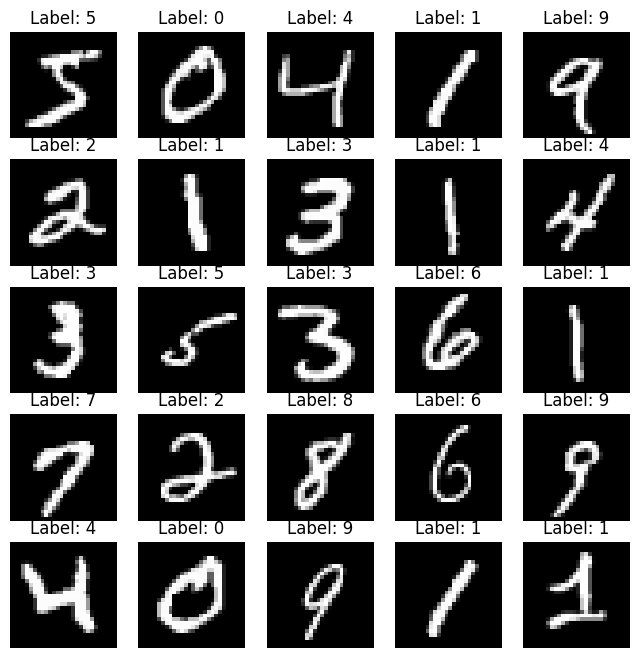

In [3]:
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.show()

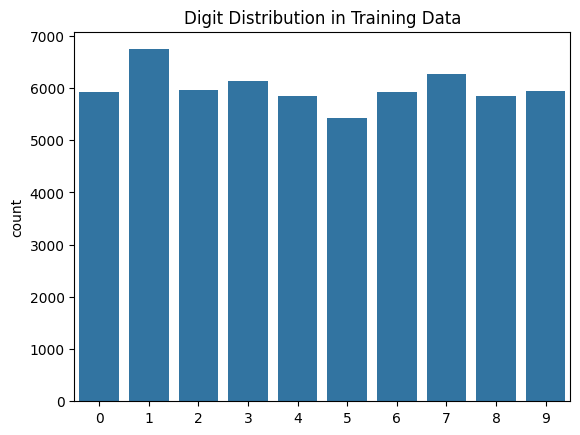

In [4]:
sns.countplot(x=y_train)
plt.title("Digit Distribution in Training Data")
plt.show()

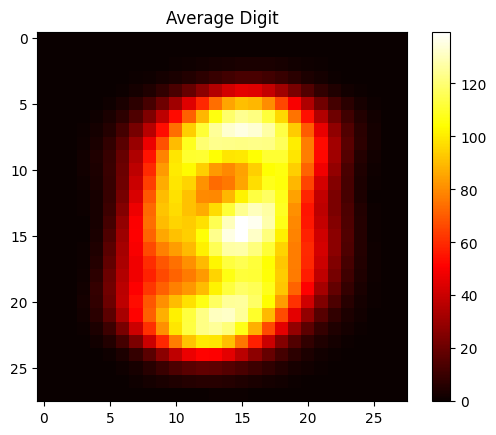

In [5]:
mean_digit = np.mean(X_train, axis=0)
plt.imshow(mean_digit, cmap="hot")
plt.title("Average Digit")
plt.colorbar()
plt.show()

# Custom Made NN

In [6]:
X_train = X_train.reshape(-1, 28*28).T / 255.0
X_test = X_test.reshape(-1, 28*28).T / 255.0

In [7]:
Y_train = to_categorical(y_train, 10).T
Y_test = to_categorical(y_test, 10).T

In [8]:
def relu(Z):
    return np.maximum(0,Z)

def relu_deriv(Z):
    return (Z > 0).astype(int)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / expZ.sum(axis=0, keepdims=True)

def initialize_params(layer_dims):
    """
    layer_dims: list, e.g. [784, 128, 64, 10]
    returns dictionary of parameters
    """
    np.random.seed(42)
    params = {}
    for l in range(1, len(layer_dims)):
        params[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        params[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return params

def forward_prop(X, params):
    """
    Returns caches for backprop
    """
    caches = {"A0": X}
    L = len(params) // 2
    for l in range(1, L):
        Z = np.dot(params[f"W{l}"], caches[f"A{l-1}"]) + params[f"b{l}"]
        A = relu(Z)
        caches[f"Z{l}"], caches[f"A{l}"] = Z, A
    # Last layer → softmax
    ZL = np.dot(params[f"W{L}"], caches[f"A{L-1}"]) + params[f"b{L}"]
    AL = softmax(ZL)
    caches[f"Z{L}"], caches[f"A{L}"] = ZL, AL
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    return -np.sum(Y*np.log(AL+1e-8)) / m

def back_prop(params, caches, AL, Y):
    grads = {}
    L = len(params) // 2
    m = Y.shape[1]

    dZL = AL - Y
    grads[f"dW{L}"] = (1/m) * np.dot(dZL, caches[f"A{L-1}"].T)
    grads[f"db{L}"] = (1/m) * np.sum(dZL, axis=1, keepdims=True)

    dA_prev = np.dot(params[f"W{L}"].T, dZL)

    for l in reversed(range(1, L)):
        dZ = dA_prev * relu_deriv(caches[f"Z{l}"])
        grads[f"dW{l}"] = (1/m) * np.dot(dZ, caches[f"A{l-1}"].T)
        grads[f"db{l}"] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        if l > 1:
            dA_prev = np.dot(params[f"W{l}"].T, dZ)
    return grads

def update_params(params, grads, lr=0.01):
    L = len(params)//2
    for l in range(1, L+1):
        params[f"W{l}"] -= lr*grads[f"dW{l}"]
        params[f"b{l}"] -= lr*grads[f"db{l}"]
    return params

In [9]:
def L_layer_model(X, Y, layer_dims, lr=0.01, epochs=1000, print_cost=False):
    params = initialize_params(layer_dims)
    costs = []
    for i in range(epochs):
        AL, caches = forward_prop(X, params)
        cost = compute_cost(AL, Y)
        grads = back_prop(params, caches, AL, Y)
        params = update_params(params, grads, lr)

        if print_cost and i % 100 == 0:
            print(f"Epoch {i}, cost={cost:.4f}")
            costs.append(cost)
    return params

In [10]:
def predict(X, params):
    AL, _ = forward_prop(X, params)
    return np.argmax(AL, axis=0)

In [11]:
layers_dims = [784, 128, 64, 10]

In [12]:
params = L_layer_model(X_train, Y_train, layers_dims, lr=0.1, epochs=1000, print_cost=True)

Epoch 0, cost=2.3896
Epoch 100, cost=0.3730
Epoch 200, cost=0.2893
Epoch 300, cost=0.2514
Epoch 400, cost=0.2261
Epoch 500, cost=0.2070
Epoch 600, cost=0.1919
Epoch 700, cost=0.1792
Epoch 800, cost=0.1681
Epoch 900, cost=0.1585


In [13]:
y_pred = predict(X_test, params)
acc = np.mean(y_pred == y_test)
print(f"Custom NN Accuracy: {acc*100:.2f}%")

Custom NN Accuracy: 95.40%
